## Momentum Trading Strategy with Polars

Let's implement a trading strategy consisting in selecting the $b$ sectors with the highest returns of year $t-1$ and then invest in year $t$ in a portfolio of them with weigths that are inversally proportional to their standard deviations. The weights are daily updated along all  year $t$. Note that the investment strategy for a day is always decided on the previous day.

The trading strategy will be benchmarked with a pure diversification strategy consisting in a portfolio of $n$ sectors with weights $1/n$.

Of course, this is an excuse to get me familiar with `polars`

In [1]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt

text = "data/quantitative_investment_strategy.csv"
df_nominal = pl.read_csv(text).with_columns(pl.col("date").str.to_datetime("%Y-%m-%d"))
df_nominal = df_nominal.with_columns(pl.all().exclude("date")/100)
df = df_nominal.with_columns(pl.all().exclude("date")/pl.all().exclude("date").shift(1)-1).with_row_count("row_nr")
df = df.filter(pl.col("row_nr") != 0)
df = df.drop("row_nr")
df.head()

date,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,Cnstr,Steel,FabPr,ElcEq,Autos,Carry,Mines,Coal,Oil,Util,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1990-01-03 00:00:00,-0.0067,-0.0057,0.011,-0.0001,-0.0073,0.0019,0.0014,0.0056,0.0044,-0.0045,0.0032,0.0145,0.0025,0.0023,-0.0003,0.0092,-0.012,0.0315,-0.0134,-0.0053,-0.0057,0.0017,0.0032,0.0028,-0.0071,-0.0049,0.0062,-0.0062,0.0041,0.0016
1990-01-04 00:00:00,-0.00745,-0.007141,-0.031553,-0.002,-0.000101,-0.004691,-0.004993,-0.00527,-0.005675,-0.006027,-0.001396,0.002563,-0.007182,-0.004989,-0.003901,0.00436,0.010931,-0.032962,-0.011048,-0.012768,-0.019008,0.002096,0.003987,-0.002792,-0.003726,-0.007436,-0.000894,-0.016402,-0.004482,-0.007788
1990-01-05 00:00:00,-0.0071,-0.009117,0.003881,-0.000701,-0.010075,-0.008022,0.002108,-0.013396,-0.003104,-0.00758,-0.00549,-0.001475,-0.006832,-0.009024,-0.013356,-0.003058,0.026932,0.000401,-0.010352,-0.013136,-0.018659,-0.006177,-0.003475,-0.0082,-0.007076,-0.004354,-0.004775,-0.012685,-0.005802,0.001107
1990-01-08 00:00:00,-0.000409,0.012676,-0.025944,0.0,-0.000305,0.005863,-0.008613,0.005674,0.001507,-0.011609,0.003714,0.003643,0.004451,0.004857,0.001425,0.004057,-0.011699,0.0002,0.010874,-0.001651,0.011283,0.003508,0.006576,0.007058,0.002443,-0.000305,0.001799,0.015439,-0.001308,-0.002513
1990-01-09 00:00:00,-0.007358,-0.009792,-0.020785,-0.005014,-0.010282,-0.00603,-0.017274,-0.010277,-0.006218,-0.004739,-0.0033,-0.009713,-0.008259,-0.013191,-0.0062,-0.013404,0.001874,-0.020038,-0.012294,-0.006202,-0.014773,-0.010888,-0.007127,-0.00821,-0.007719,-0.004577,-0.01317,-0.007959,-0.00927,-0.011185


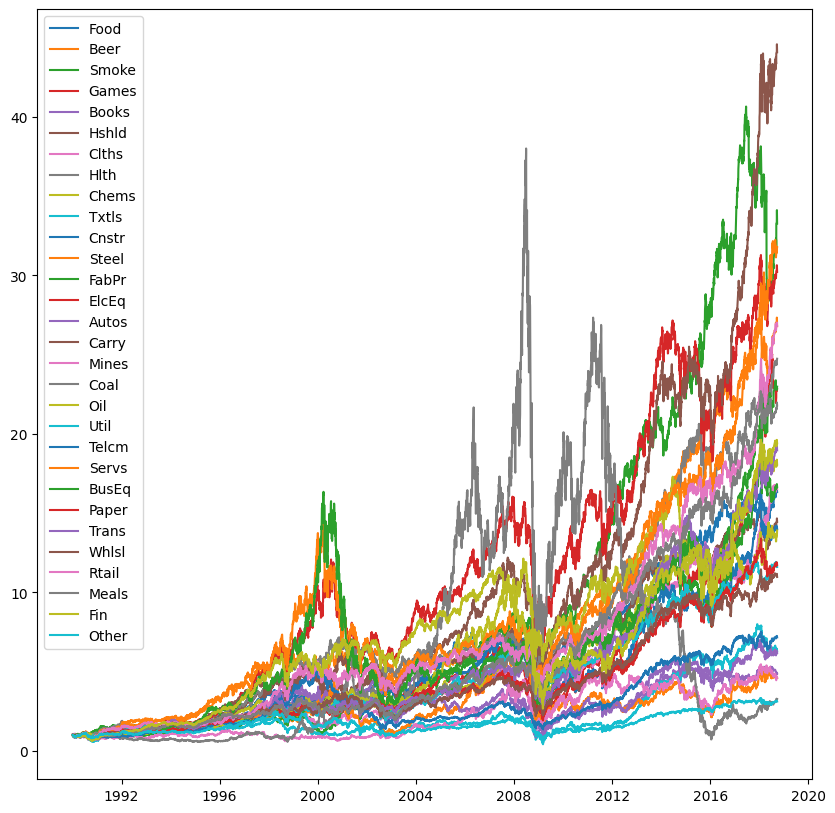

In [2]:
plt.figure(figsize=(10,10));
plt.plot(df_nominal["date"], df_nominal.select(pl.all().exclude("date")), label=df.select(pl.all().exclude("date")).columns);
plt.legend();

In [3]:
window_size = 252

# create df with rolling means and df with rolling std
means = df.with_columns(
    pl.all().exclude("date").rolling_mean(window_size=window_size).shift(1)
).with_row_count("row_nr").filter(pl.col("row_nr") >= window_size).drop("row_nr")
stds = df.with_columns(
    pl.all().exclude("date").rolling_std(window_size=window_size).shift(1)
).with_row_count("row_nr").filter(pl.col("row_nr") >= window_size).drop("row_nr")

In [4]:
def find_topmean(df_means, b=5, row=0):
    # find best b stocks for the first date
    dic = df_means.select(pl.all().exclude("date")).to_dicts()[row]
    return list(dict(sorted(dic.items(), key = lambda x: x[1], reverse = True)[:b]).keys())

def inverse_std_weights(stocks_list, std_df, starting_row=0):
    row_sum = std_df[stocks_list].select(pl.all()**(-1)).sum(axis=1)
    # add assert
    return std_df[["date"]+stocks_list].with_columns(pl.all().exclude("date")**(-1)/row_sum)

In [5]:
capital_t0 = 1_000.0
capital_history = pl.DataFrame({"date":df[window_size]["date"], "capital":capital_t0})
b = 15

capital = capital_t0
top_stocks = find_topmean(means, b)
weights = inverse_std_weights(top_stocks, std_df=stds)
year = df["date"][window_size].year

for day in range(len(df)-window_size):
    portfolio = weights.select(pl.all().exclude("date"))[day] * capital
    returns = 1 + df[top_stocks][day+window_size].to_numpy()[0].T 
    capital = portfolio.to_numpy()[0] @ returns
    capital_history.extend(pl.DataFrame({"date":df[window_size+ day]["date"], "capital":capital}))

In [6]:
capital_t0 = 1_000.0
capital_history_yearlstrat = pl.DataFrame({"date":df[window_size]["date"], "capital":capital_t0})
b = 15

capital = capital_t0
top_stocks = find_topmean(means, b)
weights = inverse_std_weights(top_stocks, std_df=stds)
year = df["date"][window_size].year

for day in range(len(df)-window_size):
    portfolio = weights.select(pl.all().exclude("date"))[day] * capital
    returns = 1 + df[top_stocks][day+window_size].to_numpy()[0].T 
    capital = portfolio.to_numpy()[0] @ returns
    capital_history_yearlstrat.extend(pl.DataFrame({"date":df[window_size+ day]["date"], "capital":capital}))

    # new best stocks at the end of the year
    if year < df["date"][day + window_size].year:
        new_top_stocks = find_topmean(means, b, row = day)
        weights = inverse_std_weights(top_stocks, std_df=stds)
        year = df["date"][day + window_size].year
        print(year, "IN: ", set(new_top_stocks).difference(top_stocks), " | OUT: ", set(top_stocks).difference(new_top_stocks))
        top_stocks = new_top_stocks


1992 IN:  {'Cnstr', 'Chems', 'Txtls', 'Meals', 'Clths', 'Trans', 'Fin'}  | OUT:  {'BusEq', 'Util', 'Carry', 'Other', 'Paper', 'Smoke', 'Oil'}
1993 IN:  {'Games', 'Telcm', 'Autos', 'Steel', 'Books'}  | OUT:  {'Cnstr', 'Chems', 'Food', 'Hlth', 'Beer'}
1994 IN:  {'FabPr', 'BusEq', 'Cnstr', 'Carry', 'Mines'}  | OUT:  {'Txtls', 'Rtail', 'Clths', 'Servs', 'Fin'}
1995 IN:  {'Chems', 'Food', 'Paper', 'Clths', 'Hlth', 'Servs', 'Smoke', 'Oil', 'Beer'}  | OUT:  {'Cnstr', 'Games', 'Meals', 'Mines', 'Telcm', 'Trans', 'Books', 'Whlsl', 'Autos'}
1996 IN:  {'Cnstr', 'Util', 'Meals', 'Telcm', 'Trans', 'Fin'}  | OUT:  {'Chems', 'Paper', 'Clths', 'Smoke', 'Oil', 'Steel'}
1997 IN:  {'Coal', 'Chems', 'Other', 'Clths', 'Paper', 'Oil'}  | OUT:  {'FabPr', 'Util', 'Meals', 'Telcm', 'Hlth', 'Trans'}
1998 IN:  {'Games', 'Util', 'Telcm', 'Rtail', 'Hlth', 'Smoke', 'Trans', 'Books'}  | OUT:  {'Coal', 'BusEq', 'Chems', 'Carry', 'Other', 'Clths', 'Paper', 'Oil'}
1999 IN:  {'Coal', 'BusEq', 'Meals', 'Autos'}  | OUT:  

In [7]:
capital_benchmark = pl.DataFrame({"date":df[window_size]["date"], "capital":capital_t0})

capital = capital_t0
weights = np.array([1/(df.shape[1]-1) for i in range(df.shape[1]-1)])
for day in range(len(df)-window_size):
    portfolio = weights * capital
    returns = 1 + df.select(pl.all().exclude("date"))[day+window_size].to_numpy()[0].T 
    capital = portfolio @ returns
    capital_benchmark.extend(pl.DataFrame({"date":df[window_size+ day]["date"], "capital":capital}))
        

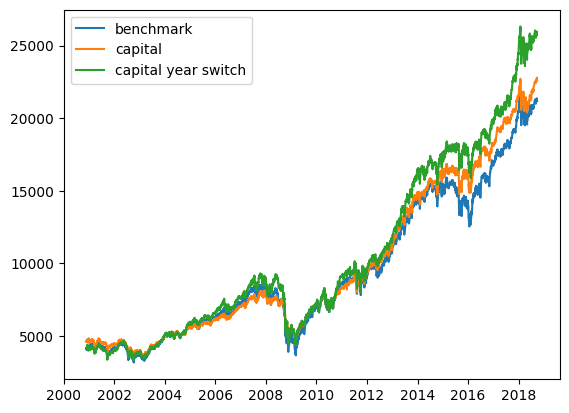

In [8]:
burn = 2500

plt.plot(capital_benchmark["date"][burn:], capital_benchmark["capital"][burn:], label="benchmark");
plt.plot(capital_history["date"][burn:], capital_history["capital"][burn:], label = "capital");
plt.plot(capital_history_yearlstrat["date"][burn:], capital_history_yearlstrat["capital"][burn:], label = "capital year switch");

plt.legend();